## Solving:

## Quantum ring and ellipse

## Import libraries

In [1]:
import kwant
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

import os.path
def save_image(name):
    folder = "./figures/"
    if os.path.exists(folder + name + ".png"):
        raise Exception("File already exist")
        return 0
    
    plt.savefig(folder + name + ".png", dpi=300)

## Create an “empty” tight binding system

In [2]:
# defining parameters
a = 1
t = 1
# lead params
W = 10
W2 = 10
# ring params
r1 = 10
r2 = 20
# ellipse params
ellipse1 = 10
ellipse2 = 20
ellipse_width = 7

#building lattice
lat = kwant.lattice.square(a)
syst = kwant.Builder()
syst2 = kwant.Builder()

## Set its matrix elements and hoppings.

In [3]:
#shape of the scattering region
def ring(pos):
    (x, y) = pos
    rsq = x ** 2 + y ** 2
    return (r1 ** 2 < rsq < r2 ** 2)

def ellipse(pos):
    (x,y) = pos
    rsq = x** 2 / ellipse1**2 + y** 2 / ellipse2**2
    u = 1 + 2 * ellipse_width / ellipse1 + (ellipse_width / ellipse1)**2
    return (1 <= rsq <= u)

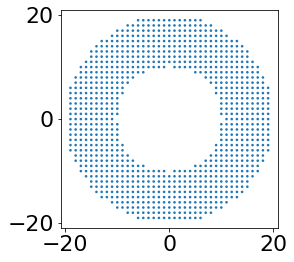

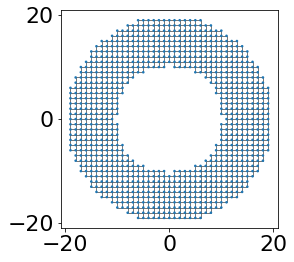

In [4]:
# defining on site values
syst[lat.shape(ring, (0, r2 - 1))] = 4 * t
_ = kwant.plot(syst)
# defining hoppings
syst[lat.neighbors()] = -t
_ = kwant.plot(syst)

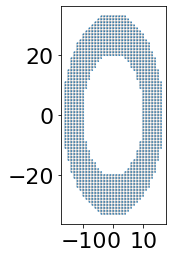

In [5]:
syst2[lat.shape(ellipse, (ellipse1 + ellipse_width/2,0))] = 4 * t
syst2[lat.neighbors()] = -t
_ = kwant.plot(syst2)

In [6]:
#new hopping values
def hopping_phase(site1, site2, phi):
    return -t * np.exp(1j * phi)

#finds the region where ix1 = 0 and iy0 <0
def crosses_branchcut(hop):
    ix0, iy0 = hop[0].tag
    return iy0 == 1 and ix0 < 0  # ix1 == 0 then implied

#selecting region from (1,0) type of hoppings
def hops_across_cut(syst):
    for hop in kwant.builder.HoppingKind((1, 0), lat, lat)(syst):
        if crosses_branchcut(hop):
            yield hop
syst[hops_across_cut] = hopping_phase

In [7]:
syst2[hops_across_cut] = hopping_phase

## Attach leads (tight binding systems with translational symmetry).

In [8]:
#using translational simmetry in y direction
sym_lead = kwant.TranslationalSymmetry((0, a))
lead = kwant.Builder(sym_lead)
lead2 = kwant.Builder(sym_lead)

#defining lead connection
def lead_shape(pos):
    (x, y) = pos
    return (-W / 2 < x < W / 2)

def lead_shape2(pos):
    (x, y) = pos
    return (-W2 / 2 < x < W2 / 2)

lead[lat.shape(lead_shape, (0, 0))] = 4 * t
lead[lat.neighbors()] = -t

lead2[lat.shape(lead_shape2, (0, 0))] = 4 * t
lead2[lat.neighbors()] = -t

In [9]:
#attaching leads
syst.attach_lead(lead)
syst.attach_lead(lead.reversed())

syst2.attach_lead(lead)
syst2.attach_lead(lead.reversed())

[]

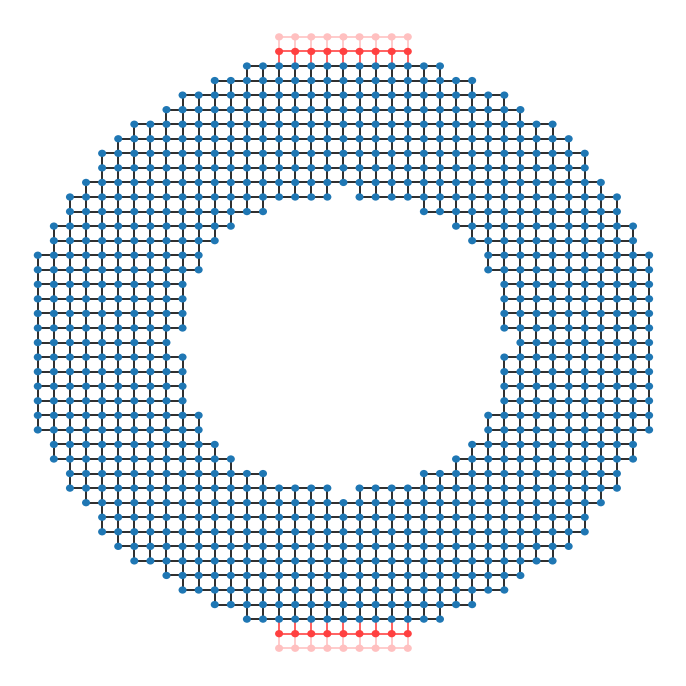

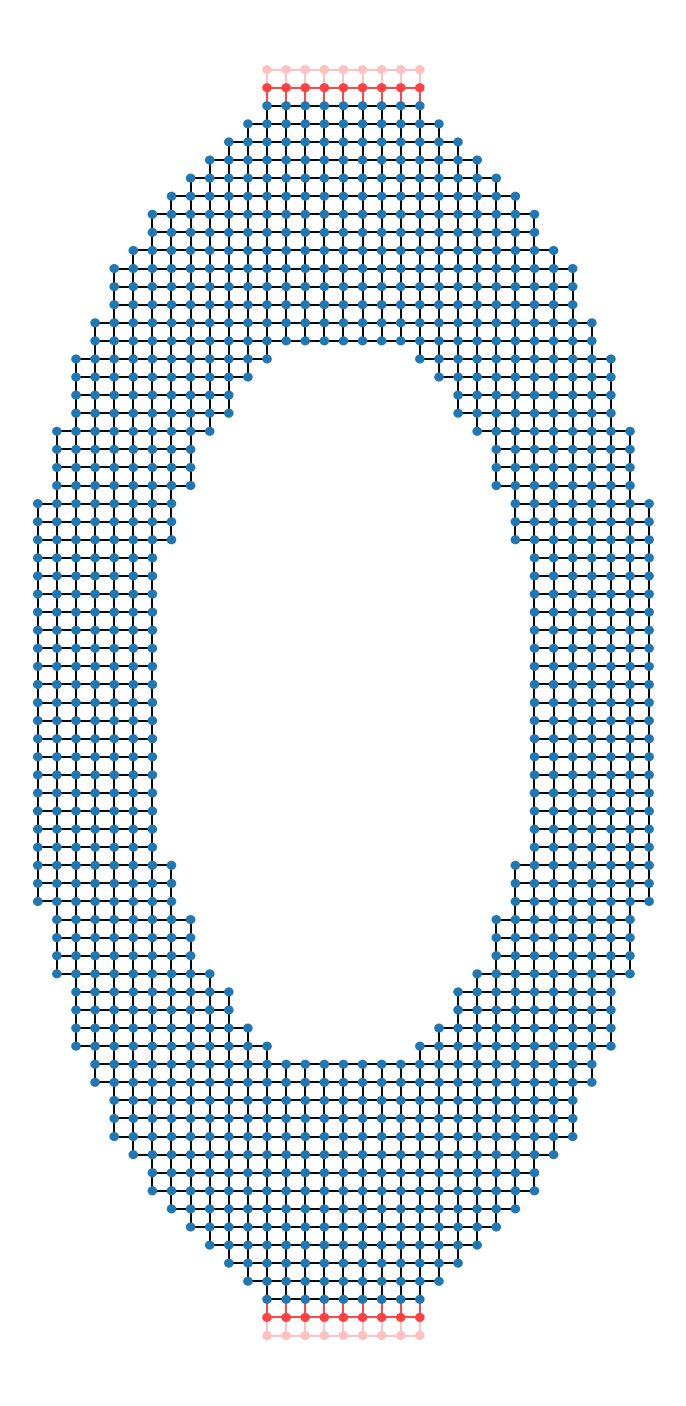

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.axis('off')
fig.tight_layout()
_ = kwant.plot(syst, ax=ax)
plt.savefig("./figures/" + "circle" + ".png", dpi=300)

fig, ax = plt.subplots(1,1, figsize=(10,20))
ax.axis('off')
fig.tight_layout()
_ = kwant.plot(syst2, ax=ax)
plt.savefig("./figures/" + "ellipse" + ".png", dpi=300)

In [11]:
syst = syst.finalized()
syst2 = syst2.finalized()

## Pass the finalized system to a solver.

In [12]:
#define params
energy=0.15
fluxes=np.linspace(0,100,100) * 3 * 2 * np.pi
normalized_fluxes = fluxes / (2 * np.pi)

In [13]:
data = []
data2 = []

for flux in fluxes:
    # compute the scattering matrix at a given energy
    smatrix = kwant.smatrix(syst, energy, params=dict(phi=flux))
    smatrix2 = kwant.smatrix(syst2, energy, params=dict(phi=flux))
    
    # compute the transmission probability
    data.append(smatrix.transmission(1, 0))
    data2.append(smatrix2.transmission(1, 0))

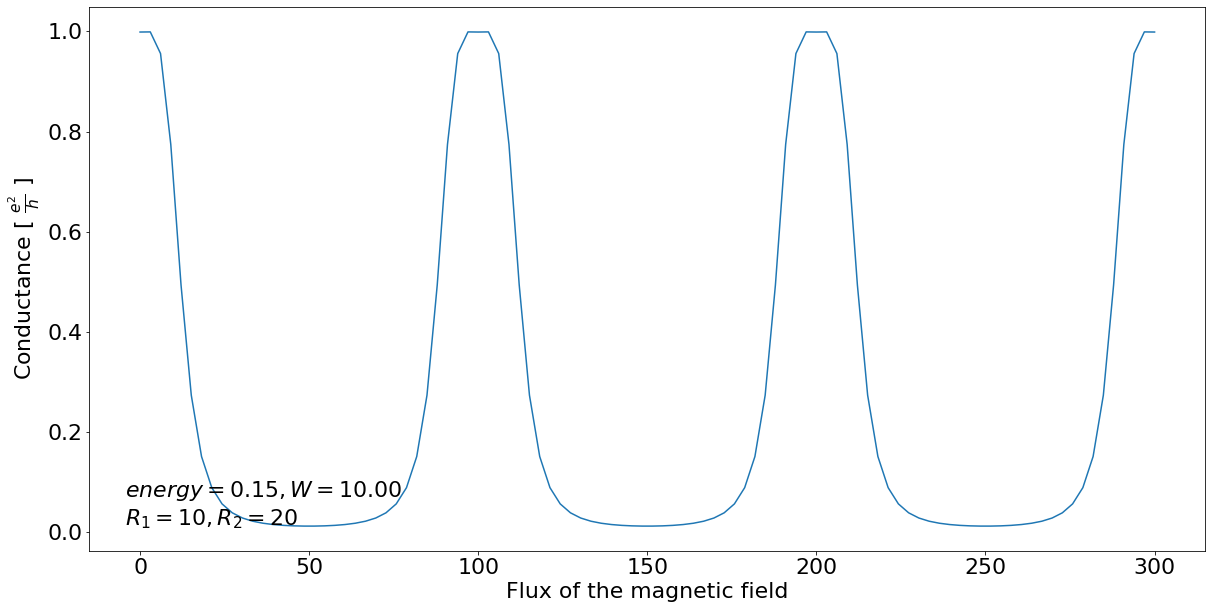

In [14]:
plt.figure(figsize=(20,10))
plt.plot(normalized_fluxes, data)

plt.xlabel("Flux of the magnetic field")
plt.ylabel(r'Conductance [ $\frac{e^2}{h}$ ]')
plt.figtext(.15, .16, r'$R_1=%d, R_2=%d$' %(r1,r2))
plt.figtext(.15, .2, r'$energy=%.2f, W=$%.2f' %(energy, W))

save_image("conductance4.1")

plt.show()

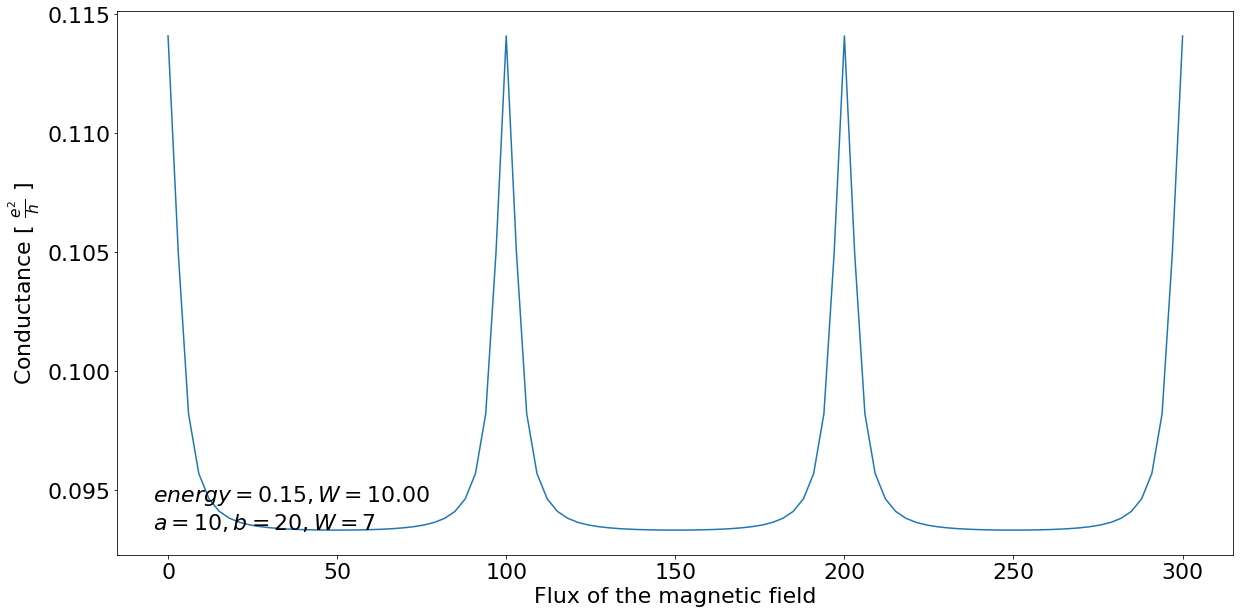

In [15]:
plt.figure(figsize=(20,10))
plt.plot(normalized_fluxes, data2)

plt.xlabel("Flux of the magnetic field")
plt.ylabel(r'Conductance [ $\frac{e^2}{h}$ ]')
plt.figtext(.15, .16, r'$a=%d, b=%d, W=%d$' %(ellipse1, ellipse2, ellipse_width))
plt.figtext(.15, .2, r'$energy=%.2f, W=$%.2f' %(energy, W2))

save_image("conductance4.2")

plt.show()